In [19]:
import sys
import os
#os.environ['TF_CUDNN_DETERMINISTIC'] = 'true'
os.environ['TENSORPACK_FP16'] = 'true'
sys.path.append('/mask-rcnn-tensorflow/MaskRCNN')
import tensorflow as tf
import tqdm
import numpy as np
import tensorpack.utils.viz as tpviz
from tensorpack import *
from tensorpack.tfutils.common import get_tf_version_tuple
from model.generalized_rcnn import ResNetFPNModel
from config import finalize_configs, config as cfg
from eval import DetectionResult, predict_image, multithread_predict_dataflow, EvalCallback
from performance import ThroughputTracker, humanize_float
from data import get_eval_dataflow, get_train_dataflow, get_batch_train_dataflow
from train import do_visualize, do_evaluate, do_predict
from dataset import DetectionDataset
from viz import draw_annotation, draw_final_outputs, draw_predictions, draw_proposal_recall, gt_mask, apply_masks, draw_outputs
import matplotlib.pyplot as plt
from cv2 import cvtColor
from tensorpack.utils.palette import PALETTE_RGB
import cv2
from skimage import io

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.








/usr/local/lib/python3.6/dist-packages/numba/errors.py:131: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [38]:
MODEL = ResNetFPNModel(True)
trained_model = '/logs/model-11244.index'
DetectionDataset()
cfg.DATA.BASEDIR = '/data/coco/'
#cfg.DATA.BASEDIR = '/home/ec2-user/small_data'
cfg.BACKBONE.WEIGHTS = '/data/coco/pretrained-models/ImageNet-R50-AlignPadding.npz'
finalize_configs(is_training=False)
pred = OfflinePredictor(PredictConfig(
        model=MODEL,
        session_init=get_model_loader(trained_model),
        input_names=['images', 'orig_image_dims'],
        output_names=[
            'generate_{}_proposals_topk_per_image/boxes'.format('fpn' if cfg.MODE_FPN else 'rpn'),
            'generate_{}_proposals_topk_per_image/scores'.format('fpn' if cfg.MODE_FPN else 'rpn'),
            'fastrcnn_all_scores',
            'output/boxes',
            'output/scores',
            'output/labels',
            'output/masks'
        ]))

[1107 17:01:27 @config.py:285] Config: ------------------------------------------
{'BACKBONE': {'FREEZE_AFFINE': False,
              'FREEZE_AT': 2,
              'NORM': 'FreezeBN',
              'RESNET_NUM_BLOCKS': [3, 4, 6, 3],
              'STRIDE_1X1': False,
              'TF_PAD_MODE': False,
              'WEIGHTS': '/data/coco/pretrained-models/ImageNet-R50-AlignPadding.npz'},
 'DATA': {'BASEDIR': '/data/coco/',
          'CLASS_NAMES': ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
                          'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign',
                          'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
                          'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag',
                          'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite',
                          'baseball bat', 'baseball glove', 'skateboard', 'surfbo

In [59]:
#image_url = "https://www.washingtonpost.com/resizer/s8Lyf-phIfV0FYCmrBR1j5EIHyk=/1248x701/arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/L5GO6PX3H4I6TCIGVNVWBXUREQ.jpg"
#image_url = "https://www.washingtonpost.com/resizer/wSFAIAbCGCi-_KhJyseh2rqSF-g=/1248x701/arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/3GGBUPK3GZA2DMKRXSKD4TP34M"
image_url = "https://i.kinja-img.com/gawker-media/image/upload/c_scale,f_auto,fl_progressive,q_80,w_1600/ekpvcpwo560egadg2mvm.jpg"
#image_url = "https://fivethirtyeight.com/wp-content/uploads/2019/11/GettyImages-1182527640-1-e1572981138469.jpg?w=1150"
#image_url = "https://fivethirtyeight.com/wp-content/uploads/2019/10/GettyImages-1001876214-4x3.jpg?w=1150"

In [60]:
img = io.imread(image_url)
#arr = np.asarray(bytearray(req.read()), dtype=np.uint8)

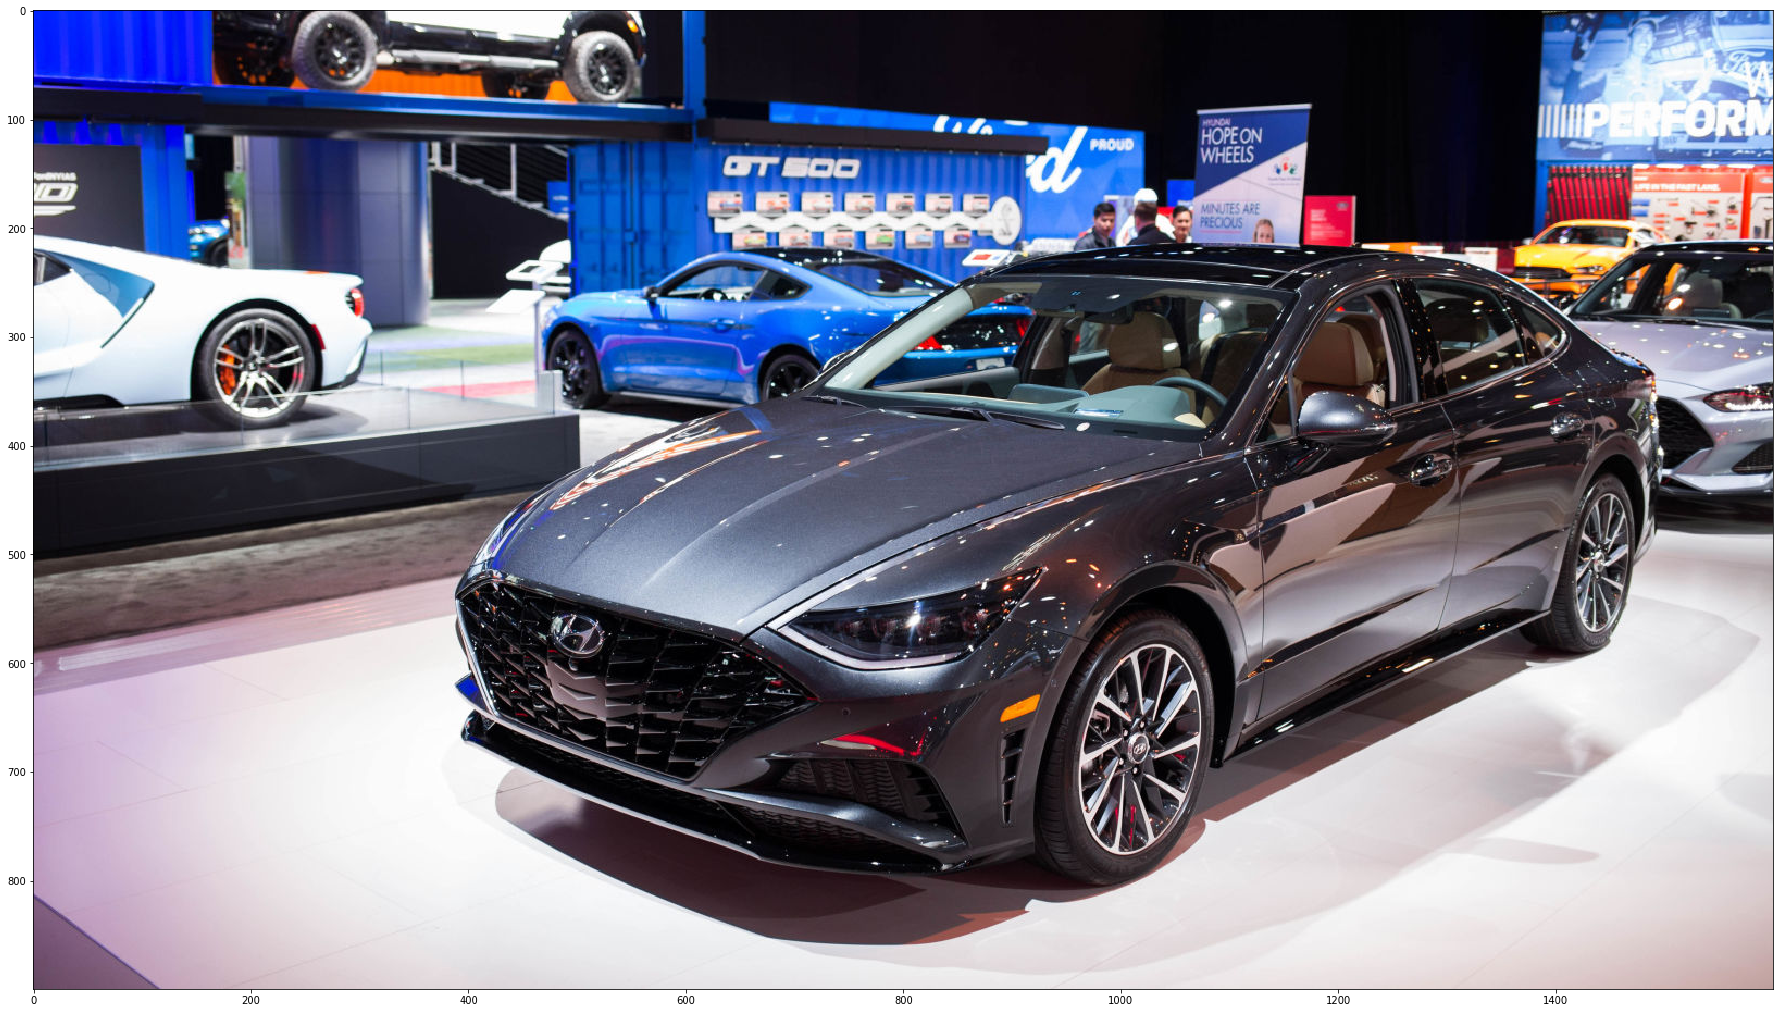

In [61]:
fig,ax = plt.subplots(figsize=(img.shape[1]//50, img.shape[0]//50))
ax.imshow(img.astype(int))

In [62]:
rpn_boxes, rpn_scores, all_scores, final_boxes, final_scores, final_labels, masks = pred(np.expand_dims(img, axis=0),
                                                                                  np.expand_dims(np.array(img.shape), axis=0))

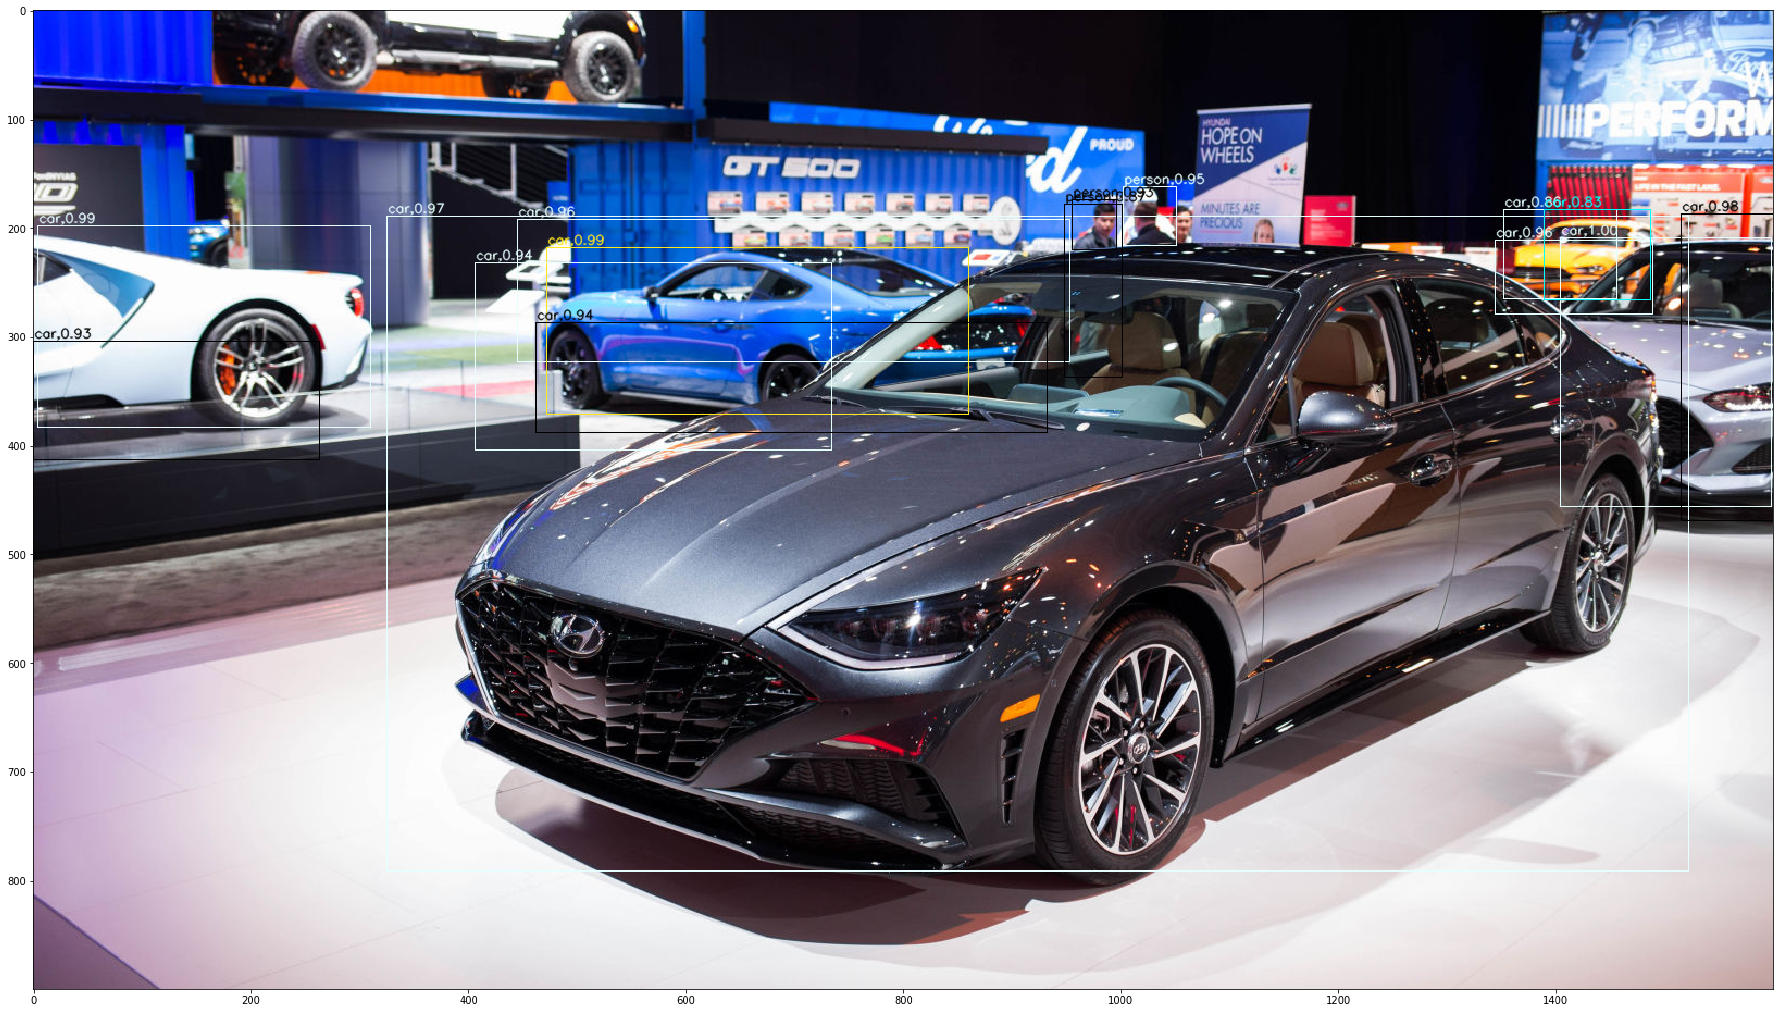

In [63]:
final_viz = draw_outputs(img, final_boxes, final_scores, final_labels, threshold=0.8)
fig,ax = plt.subplots(figsize=(img.shape[1]//50, img.shape[0]//50))
ax.imshow(final_viz/255.)

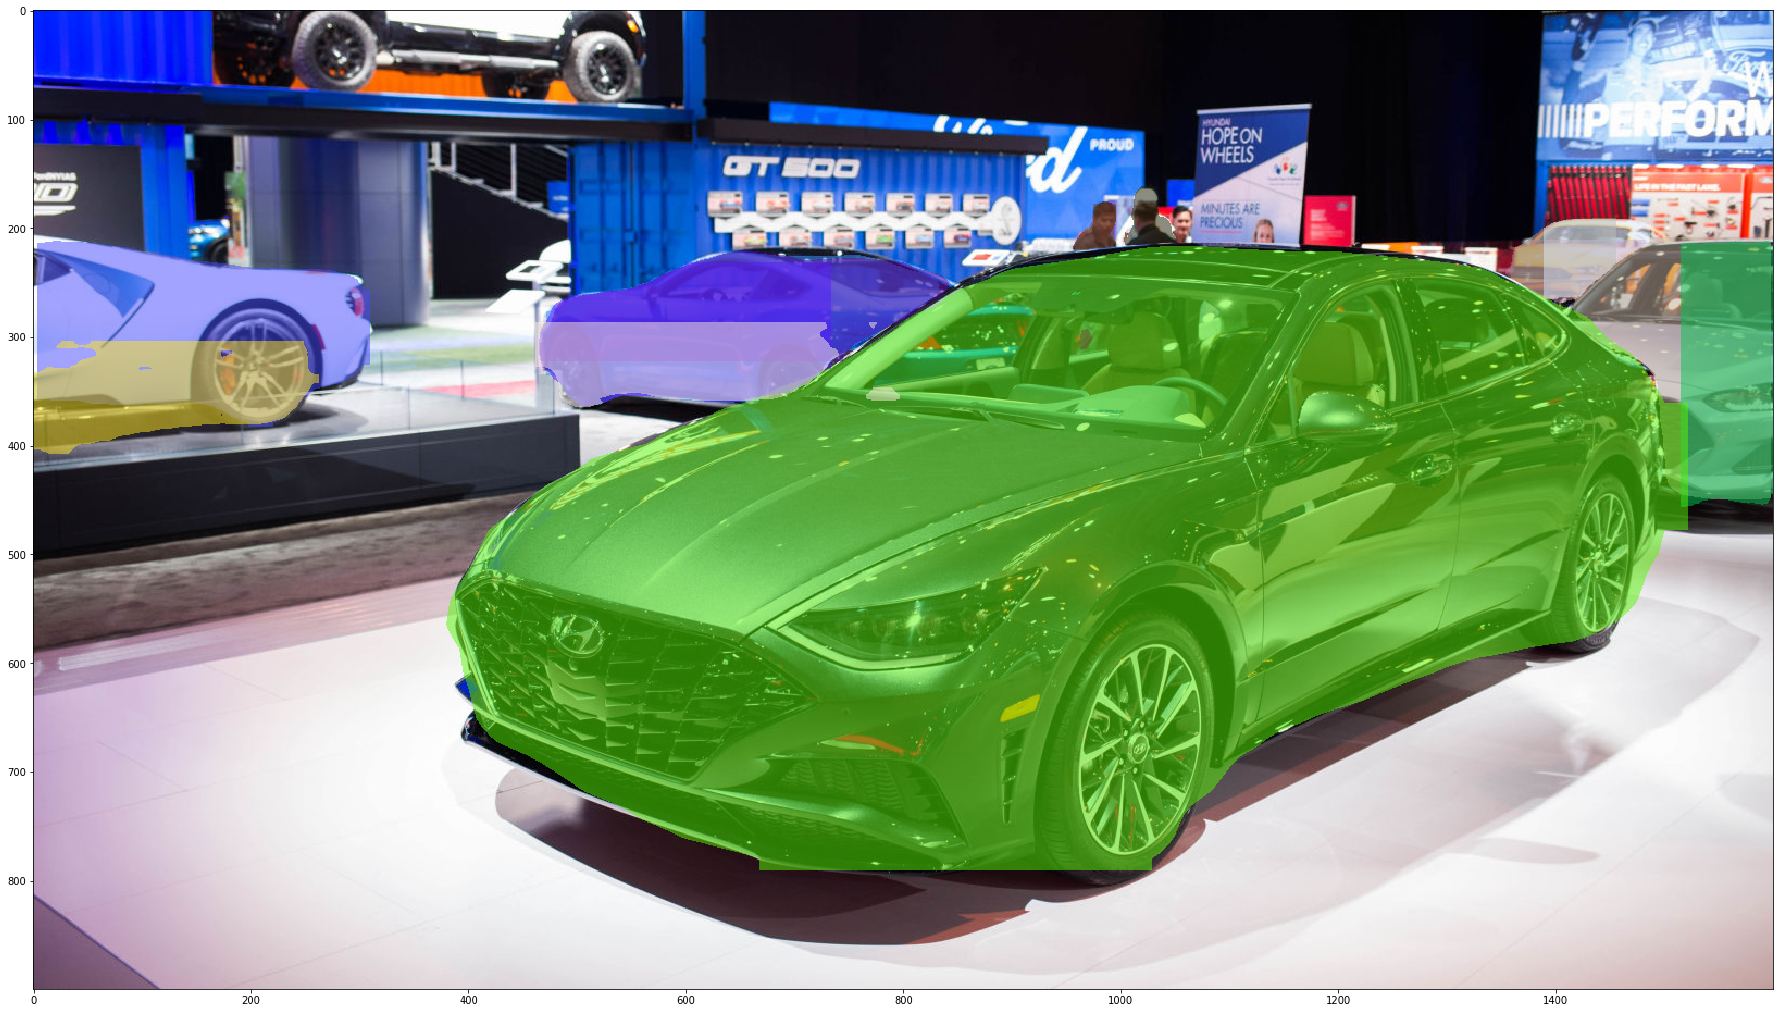

In [64]:
masked_image = apply_masks(img, final_boxes, masks, final_scores, score_threshold=.8, mask_threshold=0.5)
fig,ax = plt.subplots(figsize=(img.shape[1]//50, img.shape[0]//50))
ax.imshow(masked_image/255.)